# Hackathon santé

In [42]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des données

### Médecins
Le fichier source provient de l'addresse suivante:
https://www.data.gouv.fr/fr/datasets/honoraires-des-professionnels-de-sante-liberaux/

In [43]:
file = 'Honoraires_totaux_des_professionnels_de_sante_par_departement_en_2016.xls'
df_med = pd.read_excel(file, sheet_name='Spécialistes')
columns = ['Spécialistes', 'DEPARTEMENT', 'EFFECTIFS', 'HONORAIRES SANS DEPASSEMENT (Euros)', 'DEPASSEMENTS (Euros)']
df_med = df_med[columns]
df_med.head()

,Spécialistes,DEPARTEMENT,EFFECTIFS,HONORAIRES SANS DEPASSEMENT (Euros),DEPASSEMENTS (Euros)
0,02- Anesthésie-réanimation chirurgicale,01- Ain,17,4.53008e+06,2.49618e+06
1,02- Anesthésie-réanimation chirurgicale,02- Aisne,19,4.98526e+06,373838
2,02- Anesthésie-réanimation chirurgicale,03- Allier,19,5.1029e+06,560979
3,02- Anesthésie-réanimation chirurgicale,04- Alpes-Hte-Provence,4,nc,nc
4,02- Anesthésie-réanimation chirurgicale,05- Hautes-Alpes,5,nc,nc


### Population

Le fichier source provient de l'adresse suivante:
https://www.insee.fr/fr/statistiques/1893198

In [44]:
file = 'estim-pop-dep-sexe-gca-1975-2018.xls'
df_pop = pd.read_excel(file, sheet_name='2016', skiprows=4)
columns = ['Unnamed: 0', 'Unnamed: 1', 'Total','20 à 39 ans.2','40 à 59 ans.1']
df_pop = df_pop[columns]
df_pop.head()

,Unnamed: 0,Unnamed: 1,Total,20 à 39 ans.2,40 à 59 ans.1
0,01,Ain,637867,73736,88712
1,02,Aisne,537423,59089,71769
2,03,Allier,340785,32074,45208
3,04,Alpes-de-Haute-Provence,161814,15151,21758
4,05,Hautes-Alpes,141197,14246,19616


In [45]:
file = 'estim-pop-dep-sexe-aq-1975-2018.xls'
df_pop_age = pd.read_excel(file, sheet_name='2016', skiprows=4)
df_pop_age_transf = df_pop_age.copy()
df_pop_age_transf = df_pop_age_transf.rename(index=str, columns={"Unnamed: 0": "DEPARTEMENT_NUM", "Unnamed: 1": "DEPARTEMENT_NOM","0 à 4 ans": "0-4","65 à 69 ans": "65-69","70 à 74 ans": "70-74","75 à 79 ans": "75-79","80 à 84 ans": "80-84","85 à 89 ans": "85-89","90 à 94 ans": "90-94","95 ans et plus":"95-"})
df_pop_age_transf.head()

,DEPARTEMENT_NUM,DEPARTEMENT_NOM,0-4,5 à 9 ans,10 à 14 ans,15 à 19 ans,20 à 24 ans,25 à 29 ans,30 à 34 ans,35 à 39 ans,...,55 à 59 ans.2,60 à 64 ans.2,65 à 69 ans.2,70 à 74 ans.2,75 à 79 ans.2,80 à 84 ans.2,85 à 89 ans.2,90 à 94 ans.2,95 ans et plus.2,Total.2
0,01,Ain,39758.0,44566.0,43975.0,38722.0,29573.0,35715.0,40599.0,42081.0,...,20403.0,18715.0,17961.0,11961.0,9811.0,9138.0,6776.0,3625.0,889.0,323099.0
1,02,Aisne,32675.0,35227.0,35718.0,33264.0,25933.0,29856.0,31343.0,30998.0,...,18491.0,18377.0,17885.0,10074.0,10005.0,9833.0,6966.0,3441.0,618.0,276021.0
2,03,Allier,15882.0,18048.0,19039.0,18217.0,14895.0,15488.0,16997.0,17341.0,...,12431.0,13274.0,13417.0,9220.0,8568.0,8677.0,6461.0,3244.0,806.0,177390.0
3,04,Alpes-de-Haute-Provence,7815.0,8764.0,9523.0,8710.0,6265.0,7178.0,8285.0,8463.0,...,6067.0,5800.0,6323.0,4614.0,3871.0,3416.0,2596.0,1436.0,350.0,83030.0
4,05,Hautes-Alpes,7177.0,8234.0,8547.0,7493.0,5880.0,6762.0,7819.0,8254.0,...,5012.0,5129.0,4881.0,3354.0,3009.0,2740.0,2011.0,1186.0,342.0,72116.0


## Transformation et nettoyage des données

### Médecins

In [46]:
df_med_transf = df_med.rename(index=str, columns={"Spécialistes": "SPECIALISTES", "HONORAIRES SANS DEPASSEMENT (Euros)": "HONORAIRES", "DEPASSEMENTS (Euros)": "DEPASSEMENTS"})
# Purge empty values
df_med_transf = df_med_transf.loc[df_med_transf['DEPASSEMENTS'] != 'nc']
df_med_transf = df_med_transf.loc[df_med_transf['HONORAIRES'] != 'nc']
df_med_transf = df_med_transf.loc[df_med_transf['EFFECTIFS'] != 0]
# Take only departments which are starting with digits
filter = df_med_transf['DEPARTEMENT'].str.contains(r'[\d]')
df_med_transf = df_med_transf[filter]
filter = df_med_transf['SPECIALISTES'].str.contains(r'TOTAL(.*)')
df_med_transf = df_med_transf[~filter]
# Format Paris
df_med_transf['DEPARTEMENT'] = df_med_transf['DEPARTEMENT'].str.replace(r'\(.*\)','').map(lambda x: x.strip())
# Remove digits
df_med_transf['SPECIALISTES'] = df_med_transf['SPECIALISTES'].str.replace(r'\d+', '').str.replace(r'^[\s]', '').str.replace(r'[^\w\s]', '').map(lambda x: x.strip())
# Cast to float
df_med_transf['DEPASSEMENTS'] = df_med_transf['DEPASSEMENTS'].astype(str).astype(float)
df_med_transf['HONORAIRES'] = df_med_transf['HONORAIRES'].astype(str).astype(float)
# Sort by department and depassement
df_med_transf = df_med_transf.sort_values(by=['DEPARTEMENT', 'DEPASSEMENTS'],  ascending=[True, False])
df_med_transf.head()

,SPECIALISTES,DEPARTEMENT,EFFECTIFS,HONORAIRES,DEPASSEMENTS
3640,Ophtalmologie,01- Ain,20,6992462.82,2530891.60
0,Anesthésieréanimation chirurgicale,01- Ain,17,4530079.33,2496180.45
1664,Radiodiagnostic et imagerie médicale,01- Ain,39,17403976.84,2374782.05
2184,Gynécologie obstétrique,01- Ain,16,2973058.99,1149660.54
4992,Chirurgie orthopédique et traumatologie,01- Ain,12,1903402.86,1010938.75


### Population

In [47]:
df_pop_transf = df_pop.rename(index=str, columns={"Unnamed: 0": "DEPARTEMENT_NUM", "Unnamed: 1": "DEPARTEMENT_NOM","Total": "POPULATION","20 à 39 ans.2": "femmes_20-39","40 à 59 ans.1": "hommes_40-59"})
df_pop_transf['DEPARTEMENT'] = df_pop_transf['DEPARTEMENT_NUM'].astype(str) + '- ' + df_pop_transf['DEPARTEMENT_NOM'].astype(str)
df_pop_transf.head()

,DEPARTEMENT_NUM,DEPARTEMENT_NOM,POPULATION,femmes_20-39,hommes_40-59,DEPARTEMENT
0,01,Ain,637867,73736,88712,01- Ain
1,02,Aisne,537423,59089,71769,02- Aisne
2,03,Allier,340785,32074,45208,03- Allier
3,04,Alpes-de-Haute-Provence,161814,15151,21758,04- Alpes-de-Haute-Provence
4,05,Hautes-Alpes,141197,14246,19616,05- Hautes-Alpes


In [48]:
df_pop_age_transf['DEPARTEMENT'] = df_pop_age_transf['DEPARTEMENT_NUM'].astype(str) + '- ' + df_pop_age_transf['DEPARTEMENT_NOM'].astype(str)
df_pop_age_transf.head()

,DEPARTEMENT_NUM,DEPARTEMENT_NOM,0-4,5 à 9 ans,10 à 14 ans,15 à 19 ans,20 à 24 ans,25 à 29 ans,30 à 34 ans,35 à 39 ans,...,60 à 64 ans.2,65 à 69 ans.2,70 à 74 ans.2,75 à 79 ans.2,80 à 84 ans.2,85 à 89 ans.2,90 à 94 ans.2,95 ans et plus.2,Total.2,DEPARTEMENT
0,01,Ain,39758.0,44566.0,43975.0,38722.0,29573.0,35715.0,40599.0,42081.0,...,18715.0,17961.0,11961.0,9811.0,9138.0,6776.0,3625.0,889.0,323099.0,01- Ain
1,02,Aisne,32675.0,35227.0,35718.0,33264.0,25933.0,29856.0,31343.0,30998.0,...,18377.0,17885.0,10074.0,10005.0,9833.0,6966.0,3441.0,618.0,276021.0,02- Aisne
2,03,Allier,15882.0,18048.0,19039.0,18217.0,14895.0,15488.0,16997.0,17341.0,...,13274.0,13417.0,9220.0,8568.0,8677.0,6461.0,3244.0,806.0,177390.0,03- Allier
3,04,Alpes-de-Haute-Provence,7815.0,8764.0,9523.0,8710.0,6265.0,7178.0,8285.0,8463.0,...,5800.0,6323.0,4614.0,3871.0,3416.0,2596.0,1436.0,350.0,83030.0,04- Alpes-de-Haute-Provence
4,05,Hautes-Alpes,7177.0,8234.0,8547.0,7493.0,5880.0,6762.0,7819.0,8254.0,...,5129.0,4881.0,3354.0,3009.0,2740.0,2011.0,1186.0,342.0,72116.0,05- Hautes-Alpes


### Fusionner médecins et population

In [49]:
df_med_transf = df_med_transf.merge(df_pop_transf, on='DEPARTEMENT')
df_med_transf = df_med_transf.drop(columns=['DEPARTEMENT_NUM', 'DEPARTEMENT_NOM'])
# Categorise SPECIALISTES
df_med_transf = df_med_transf.assign(ID_SPECIALITE=(df_med_transf['SPECIALISTES']).astype('category').cat.codes)
# Create new columns for DEPASSEMENTS/DEPASSEMENTS + HONORAIRES and by EFFECTIFS 
df_med_transf['RATIO_DEPASSEMENTS'] = df_med_transf['DEPASSEMENTS'] / (df_med_transf['DEPASSEMENTS'] + df_med_transf['HONORAIRES'])
df_med_transf['RATIO_DEPASSEMENTS_EFFECTIFS'] = df_med_transf['RATIO_DEPASSEMENTS'] / df_med_transf['EFFECTIFS']
col = ['DEPARTEMENT','SPECIALISTES','ID_SPECIALITE', 'EFFECTIFS', 'RATIO_DEPASSEMENTS_EFFECTIFS','POPULATION','femmes_20-39']
df_med_transf = df_med_transf[col]
df_med_transf.head()

,DEPARTEMENT,SPECIALISTES,ID_SPECIALITE,EFFECTIFS,RATIO_DEPASSEMENTS_EFFECTIFS,POPULATION,femmes_20-39
0,01- Ain,Ophtalmologie,25,20,0.013288,637867,73736
1,01- Ain,Anesthésieréanimation chirurgicale,1,17,0.020898,637867,73736
2,01- Ain,Radiodiagnostic et imagerie médicale,32,39,0.003079,637867,73736
3,01- Ain,Gynécologie obstétrique,14,16,0.017429,637867,73736
4,01- Ain,Chirurgie orthopédique et traumatologie,4,12,0.028907,637867,73736


### Fusionner population age et honoraires

In [52]:
df_pop_age_transf = df_pop_age_transf.merge(df_med_transf, on='DEPARTEMENT')
col = ['DEPARTEMENT','ID_SPECIALITE', 'EFFECTIFS','femmes_20-39']
df_pop_age_transf = df_pop_age_transf[col]
df_pop_age_transf.head()

,DEPARTEMENT,ID_SPECIALITE,EFFECTIFS,femmes_20-39
0,01- Ain,25,20,73736
1,01- Ain,1,17,73736
2,01- Ain,32,39,73736
3,01- Ain,14,16,73736
4,01- Ain,4,12,73736


## Analyse des données


<IPython.core.display.Javascript object>


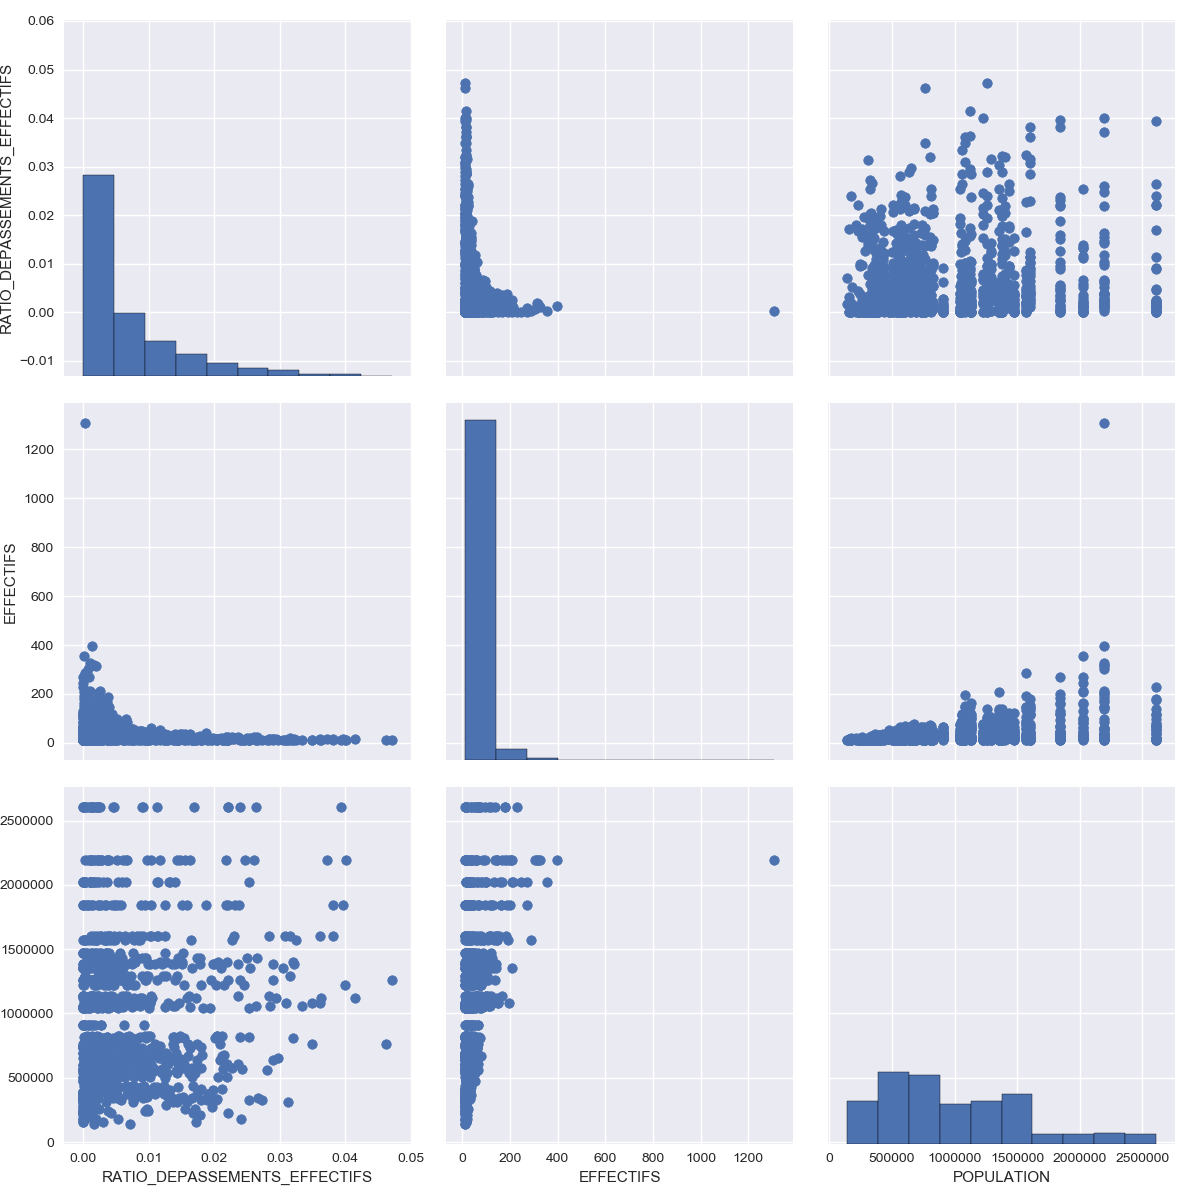

In [53]:
col = ['RATIO_DEPASSEMENTS_EFFECTIFS','EFFECTIFS','POPULATION']

grid = sns.pairplot(df_med_transf[col], size=4)
grid = grid.map_upper(plt.scatter)
grid = grid.map_diag(plt.hist, bins = 10, edgecolor = 'k')
grid = grid.map_lower(plt.scatter)

On observe que que:
- les effectifs augmentent avec la population
- les deppasements d'honoraires sont plus grands quand les effectifs de médecins sont petits
